In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import math
import imgaug.augmenters as iaa
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog, local_binary_pattern, canny
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn import svm, metrics

# TODO
# Hyper-parameter tuning
# It was observed from the confusion matrix that all classifiers performed worse in these scenarios:
# 1. Predicting label 2 as 1, and predicting label 1 as 2

In [3]:
df = pd.read_csv('./dataset/label.csv')
df.head()

,file_name,label
0,IMAGE_0000.jpg,meningioma_tumor
1,IMAGE_0001.jpg,no_tumor
2,IMAGE_0002.jpg,meningioma_tumor
3,IMAGE_0003.jpg,glioma_tumor
4,IMAGE_0004.jpg,meningioma_tumor


In [4]:
df['label'].value_counts()

glioma_tumor        860
meningioma_tumor    855
pituitary_tumor     831
no_tumor            454
Name: label, dtype: int64

In [5]:
def create_classes(df):
    '''
    Inputs
        df: Label data.
        
    Return
        classes: List of labels - 0 if no_tumor, 1 if glioma_tumor, 2 if meningioma_tumor, 3 if pituitary_tumor
    '''
    
    classes = []
    for label in df['label']:
        if 'no_tumor' in label:
            classes.append(0)
        elif 'glioma_tumor' in label:
            classes.append(1)
        elif 'meningioma_tumor' in label:
            classes.append(2)
        elif 'pituitary_tumor' in label:
            classes.append(3)
    return classes

In [20]:
data_path = './dataset/image'
images = []
for filename in df['file_name']:
    im = imread(os.path.join(data_path, filename), as_gray = True)
    resized_im = resize(im, (128, 64))
    images.append(resized_im)

# Index of images with no_tumor label
noTumor_idx = df.index[df['label']=='no_tumor'].tolist()
# Index of images with glioma_tumor label
glioma_idx = df.index[df['label']=='glioma_tumor'].tolist()
# Index of images with meningioma_tumor label
meningioma_idx = df.index[df['label']=='meningioma_tumor'].tolist()

# List of images with no_tumor label
images_noTumor = []
for idx in noTumor_idx:
    images_noTumor.append(images[idx])

# Choose random indexes of images with glioma_tumor label up to 1/4 of the total number
glioma_idx_sample = random.choices(glioma_idx, k=math.floor(len(glioma_idx)/4))
# List of images with glioma_tumor label
images_glioma = []
for idx in glioma_idx_sample:
    images_glioma.append(images[idx])

# Choose random indexes of images with meningioma_tumor label up to 1/4 of the total number
meningioma_idx_sample = random.choices(meningioma_idx, k=math.floor(len(meningioma_idx)/4))
# List of images with meningioma_tumor label
images_meningioma = []
for idx in meningioma_idx_sample:
    images_meningioma.append(images[idx])

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Flipud(0.5), # vertical flips
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    )
], random_order=True)

# Double the no_tumor images
images_aug_noTumor = seq(images=images_noTumor)
# Increases the glioma_tumor images by 1.25
images_aug_glioma = seq(images=images_glioma)
# Increases the meningioma_tumor images by 1.25
images_aug_meningioma = seq(images=images_meningioma)

# Concatenate the lists of image pixel data to form a new dataset with augmented images
images_new = images + images_aug_noTumor + images_aug_glioma + images_aug_meningioma


In [21]:
def extract_hog(images_pixelData):
    '''
    Inputs
        images_pixelData: Dataset of image pixel data.
        
    Return
       hog_features: A list of HOG features for each image.
    '''
    hog_features = []
    # for filename in df['file_name']:
    #     # use imread to load image from specified file name in grayscale
    #     im = imread(os.path.join(data_path, filename), as_gray = True)
    #     # use resize the image to a 128 by 64 pixel image
    #     resized_im = resize(im, (128, 64))
    #     # Extract Histogram of Oriented Gradients (HOG) for the image
    #     fd = hog(resized_im, orientations = 9, pixels_per_cell = (8, 8),
    #                         cells_per_block = (2, 2), visualize = False, block_norm='L2-Hys')
    #     hog_features.append(fd)

    for i in range(len(images_pixelData)):
        # Extract Histogram of Oriented Gradients (HOG) for the image
        fd = hog(images_pixelData[i], orientations = 9, pixels_per_cell = (8, 8),
                            cells_per_block = (2, 2), visualize = False, block_norm='L2-Hys')
        hog_features.append(fd)

    return hog_features

if os.path.exists('./dataset/label_taskB_hog.pkl'):
    print('The pickle file for Task B with HOG features data already exists')
else:
    data_path = './dataset/image'
    classes = create_classes(df)
    hog_features = extract_hog(images_new)
    
    label_taskB = pd.DataFrame(data = hog_features)
    # classes: List of labels - 0 if no_tumor, 1 if glioma_tumor, 2 if meningioma_tumor, 3 if pituitary_tumor
    label_taskB['num_label'] = classes + [0]*len(noTumor_idx) + [1]*len(glioma_idx_sample) + [2]*len(meningioma_idx_sample)
    label_taskB.to_pickle("./dataset/label_taskB_hog.pkl")

In [8]:
# def extract_lbp(images_pixelData, radius):
#     '''
#     Inputs
#         data_path: Directory path to images in dataset;
#         df: Label data.
        
#     Return
#        lbp_features: A list of Local Binary Pattern (LBP) features for each image
#     '''
#     numPoints = 8*radius

#     lbp_features = []
#     for i in range(len(images_pixelData)):
#         # Extract Local Binary Pattern (LBP) for the image
#         lbp = local_binary_pattern(images_pixelData[i], numPoints, radius, method="uniform")
#         # Create bins for histogram
#         n_bins = int(lbp.max() + 1)
#         # Create histogram for image
#         (hist, _) = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
        
#         # # normalize the histogram
#         # hist = hist.astype("float")
#         # hist /= (hist.sum() + eps)
        
#         lbp_features.append(hist)
#     return lbp_features

# if os.path.exists('./dataset/label_taskB_lbp.pkl'):
#     print('The pickle file for Task B with lbp features data already exists')
# else:
#     data_path = './dataset/image'
#     classes = create_classes(df)
#     lbp_features = extract_lbp(images_new, 3)
    
#     label_taskB = pd.DataFrame(data = lbp_features)
#     # classes: List of labels - 0 if no_tumor, 1 if glioma_tumor, 2 if meningioma_tumor, 3 if pituitary_tumor
#     label_taskB['num_label'] = classes + [0]*len(noTumor_idx) + [1]*len(glioma_idx_sample) + [2]*len(meningioma_idx_sample)
#     label_taskB.to_pickle("./dataset/label_taskB_lbp.pkl")

The csv file for Task B with lbp features data already exists


In [9]:
# def extract_canny(images_pixelData, sigma):
#     '''
#     Inputs
#         data_path: Directory path to images in dataset;
#         df: Label data.
        
#     Return
#        canny_features: A list of Local Binary Pattern (LBP) features for each image
#     '''
#     canny_features = []
#     for i in range(len(images_pixelData)):
#         # Compute the Canny filter for the image
#         filtered_im = canny(images_pixelData[i], sigma=sigma).ravel()
#         # filtered_im = filtered_im.ravel()

#         canny_features.append(filtered_im)

#     return canny_features

# if os.path.exists('./dataset/label_taskB_canny.pkl'):
#     print('The pickle file for Task B image data filtered with Canny filter already exists')
# else:
#     data_path = './dataset/image'
#     classes = create_classes(df)
#     canny_features = extract_canny(images_new, 3)
    
#     label_taskB = pd.DataFrame(data = canny_features)
#     # classes: List of labels - 0 if no_tumor, 1 if glioma_tumor, 2 if meningioma_tumor, 3 if pituitary_tumor
#     label_taskB['num_label'] = classes + [0]*len(noTumor_idx) + [1]*len(glioma_idx_sample) + [2]*len(meningioma_idx_sample)
#     label_taskB.to_pickle("./dataset/label_taskB_canny.pkl")

The csv file for Task B image data filtered with Canny filter already exists


In [10]:
def PCAPredict(X_train, X_test, k):
    '''
    Inputs
        X_train: Training dataset;
        X_test: Testing dataset;
        k: Number of components to use.
        
    Return
        X_train_PCA: Training dataset after applying PCA to reduce its dimensions;
        X_test_PCA: Test dataset after applying PCA to reduce its dimensions.
    '''

    # the built-in function for PCA
    pca = PCA(k)
    
    # the built-in function to standardize features by removing the mean and scaling to unit variance
    scaler = StandardScaler()

    # fit the algorithm with dataset
    
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    pca.fit(X_train_scaled)
    X_train_PCA = pca.transform(X_train_scaled)
    X_test_PCA = pca.transform(X_test_scaled)
    
    return X_train_PCA, X_test_PCA

In [11]:
def feature_selection(X_train, X_test, y_train):
    # clf = ExtraTreesClassifier(n_estimators=100)
    # clf = clf.fit(X_train, y_train)
    # model = SelectFromModel(clf, prefit=True)
    # X_train_new = model.transform(X_train)
    # X_test_new = model.transform(X_test)

    # forest = RandomForestClassifier(random_state=0)
    # forest.fit(X_train, y_train)
    # model = SelectFromModel(forest, prefit=True)
    # X_train_new = model.transform(X_train)
    # X_test_new = model.transform(X_test)

    lsvc = svm.LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
    model = SelectFromModel(lsvc, prefit=True)
    X_train_new = model.transform(X_train)
    X_test_new = model.transform(X_test)
    
    return X_train_new, X_test_new

In [28]:
feature = 'hog'

if feature == 'hog':
    # Doing classification with image HOG features
    label_taskB = pd.read_pickle("./dataset/label_taskB_hog.pkl")
elif feature == 'lbp':
    # Doing classification with image LBP features
    label_taskB = pd.read_pickle("./dataset/label_taskB_lbp.pkl")
elif feature == 'canny':
    # Doing classification with Canny filtered image data
    label_taskB = pd.read_pickle("./dataset/label_taskB_canny.pkl")
    
X = label_taskB.drop('num_label',axis=1) # All other features
Y = label_taskB['num_label'] # numerical label/classes

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 3, shuffle=True, stratify=Y) 
#test_size= should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split
#everytime you run it without specifying random_state, you will get a different result, this is expected behavior
#print (len(X_test), len(y_test))

print('train set: {}  | test set: {}'.format(round(((len(y_train)*1.0)/len(X)),3),
                                                       round((len(y_test)*1.0)/len(X),3)))

# Doing dimensionality reduction with PCA
X_train, X_test = PCAPredict(X_train, X_test, 0.95)
print('PCA done')

# Doing feature selection
X_train, X_test = feature_selection(X_train, X_test, y_train)
print(X_train.shape)


train set: 0.7  | test set: 0.3
PCA done
(2100, 824)


In [23]:
pd.Series(y_train).value_counts()

1    903
2    897
0    635
3    582
Name: num_label, dtype: int64

{'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 1}
KNN classifier score: 0.8894899536321483


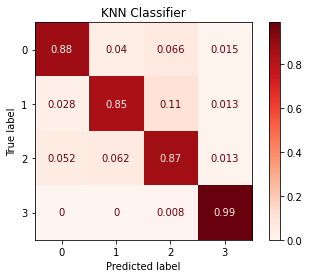

In [24]:
def KNNClassifierCV(X_train, y_train, X_test):
    '''
    Inputs
        X_train: Training dataset;
        y_train: Training labels;
        X_test: Testing dataset;
        
    Return
        Y_pred: Predicted labels from X_test using K-Nearest Neighbour.
    '''

    # Create dictionary of parameters to cross validate the estimator on
    parameters = [
    {'algorithm': ['ball_tree'], 'n_neighbors':[1, 2, 3, 4], 'leaf_size':[10, 20, 30]},
    {'algorithm': ['kd_tree'], 'n_neighbors':[1, 2, 3, 4], 'leaf_size':[10, 20, 30]},
    {'algorithm': ['brute'], 'n_neighbors':[1, 2, 3, 4]}
    ]

    # Create KNN object
    neigh = KNeighborsClassifier()
    # Exhaustive search over all chosen parameters
    clf = GridSearchCV(neigh, parameters, scoring='accuracy')
    # Fit KNN model with the parameters for cross-validation
    clf.fit(X_train, y_train) 
    print(clf.best_params_)
    # Predict labels with the best parameters from cross-validation
    Y_pred = clf.predict(X_test)
    
    disp = metrics.ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        cmap=plt.cm.Reds,
        normalize='true'
    )
    disp.ax_.set_title('KNN Classifier')
    
    return Y_pred, disp

# clf = svm.SVC()
# clf.fit(X_train, y_train)
# Y_pred = clf.predict(X_test)
# throws error: setting an array element with a sequence
# when getting X from dataframe, the resulting array is dtype object,
# but when getting X directly from hog_features, resulting array is dtype float??

Y_pred_KNN, disp_KNN = KNNClassifierCV(X_train, y_train, X_test)
score_KNN = metrics.accuracy_score(y_test, Y_pred_KNN)
print('KNN classifier score:', score_KNN)

{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 300}
Random Forest classifier score: 0.8052550231839258


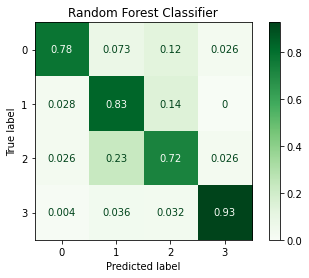

In [25]:
def RFClassifierCV(X_train, y_train, X_test):
    '''
    Inputs
        X_train: Training dataset;
        y_train: Training labels;
        X_test: Testing dataset;
        k: Number of trees in the forest.
        
    Return
        Y_pred: Predicted labels from X_test using Random Forests.
    '''
    # Create dictionary of parameters to cross validate the estimator on
    parameters = {'n_estimators':[100, 200, 300], 'criterion':['entropy', 'gini'],
    'max_features': ['sqrt', 'log2']}
    # Create Random Forest object
    RF = RandomForestClassifier()
    # Exhaustive search over all chosen parameters
    clf = GridSearchCV(RF, parameters, scoring='accuracy')
    # Fit RF model with the parameters for cross-validation
    clf.fit(X_train, y_train) 
    print(clf.best_params_)
    # Predict labels with the best parameters from cross-validation
    Y_pred = clf.predict(X_test)

    disp = metrics.ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        cmap=plt.cm.Greens,
        normalize='true'
    )
    disp.ax_.set_title('Random Forest Classifier')
    
    return Y_pred, disp

Y_pred_RandomForest, disp_RF = RFClassifierCV(X_train, y_train, X_test)
score_RandomForest = metrics.accuracy_score(y_test, Y_pred_RandomForest)
print('Random Forest classifier score:', score_RandomForest)

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
SVM classifier score: 0.7644444444444445


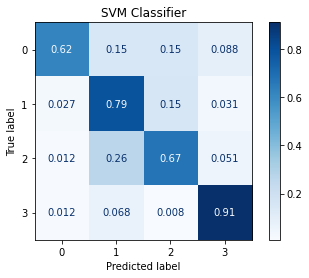

In [29]:
def SVMClassifierCV(X_train, y_train, X_test):
    '''
    Inputs
        X_train: Training dataset;
        y_train: Training labels;
        X_test: Testing dataset.
        
    Return
        Y_pred: Predicted labels from X_test using SVM.
    '''

    # Create dictionary of parameters to cross validate the estimator on
    parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4, 1e-5], "C": [1, 10, 100]},
    {"kernel": ["linear"], "C": [1, 10, 100]}
    ]
    # Create SVC object
    svc = svm.SVC()
    # Exhaustive search over all chosen parameters
    clf = GridSearchCV(svc, parameters)
    # Fit SVC model with the parameters for cross-validation
    clf.fit(X_train, y_train)
    # Predict labels with the best parameters from cross-validation
    print(clf.best_params_)
    Y_pred = clf.predict(X_test)

    # classes: List of labels - 0 if no_tumor, 1 if glioma_tumor, 2 if meningioma_tumor, 3 if pituitary_tumor
    disp = metrics.ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize='true'
    )
    disp.ax_.set_title('SVM Classifier')
    
    return Y_pred, disp

Y_pred_SVM, disp_SVM = SVMClassifierCV(X_train, y_train, X_test)
score_SVM = metrics.accuracy_score(y_test, Y_pred_SVM)
print('SVM classifier score:', score_SVM)

Voting classifier score: 0.8778979907264297


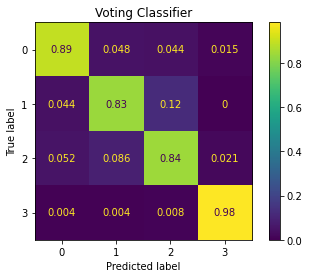

In [27]:
def voting(X_train, y_train, X_test):
    clf1 = svm.SVC(C=10, kernel='rbf', gamma=1e-4)
    clf2 = RandomForestClassifier(n_estimators=300, criterion='entropy', max_features='sqrt')
    clf3 = KNeighborsClassifier(n_neighbors=1, leaf_size=10, algorithm='ball_tree')

    eclf1 = VotingClassifier(estimators=[
        ('svc', clf1), ('rf', clf2), ('knn', clf3)], voting='hard')
    eclf1.fit(X_train, y_train)

    Y_pred = eclf1.predict(X_test)

    disp = metrics.ConfusionMatrixDisplay.from_estimator(
        eclf1,
        X_test,
        y_test,
        cmap='viridis',
        normalize='true'
    )
    disp.ax_.set_title('Voting Classifier')

    return Y_pred, disp

Y_pred_voting, disp_voting = voting(X_train, y_train, X_test)
score_voting = metrics.accuracy_score(y_test, Y_pred_voting)
print('Voting classifier score:', score_voting)

In [16]:
def baggingClassifierML(X_train, y_train, X_test,k):

    # Bagging takes Decision Tree as its base-estimator model by default.
    bagmodel=BaggingClassifier(n_estimators=k,max_samples=0.5, max_features=4,random_state=1)
    bagmodel.fit(X_train, y_train) # Fit KNN model


    Y_pred = bagmodel.predict(X_test)
    #print (Y_pred)
    
    return Y_pred

In [17]:
def boostingClassifierML(X_train, y_train, X_test,k):
    # AdaBoost takes Decision Tree as its base-estimator model by default.
    boostmodel=AdaBoostClassifier(n_estimators=k)
    boostmodel.fit(X_train, y_train,sample_weight=None) # Fit KNN model


    Y_pred = boostmodel.predict(X_test)
    #print (Y_pred)
    return Y_pred

ValueError: too many values to unpack (expected 2)

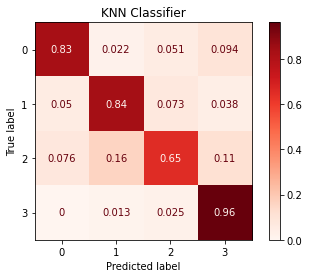

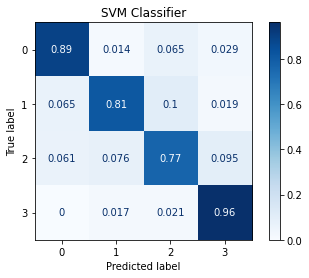

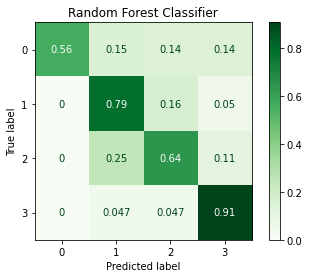

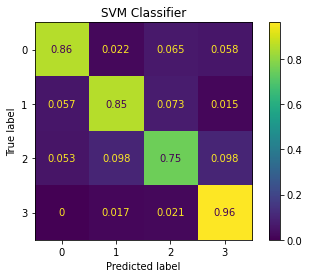

In [26]:
# Y_pred_bagging = baggingClassifierML(X_train, y_train, X_test, 10)
# score_bagging = metrics.accuracy_score(y_test, Y_pred_bagging)

# Y_pred_boosting=boostingClassifierML(X_train, y_train, X_test, 10)
# score_boosting=metrics.accuracy_score(y_test, Y_pred_boosting)

# print('Bagging classifier score:', score_bagging)
# print('ADA Boosting classifier score:', score_boosting)